Step 1: Train/Test Split

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.load("data/6_less_tensor.npz")
X = data["inputs"]
Y = data["outputs"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(len(X_train), len(X_test))

3920 436


Step 2: CNN Architecture (Pytorch)

In [2]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    """
    A small residual block:
    1) Conv -> BN -> ReLU
    2) Conv -> BN
    Then add skip connection and final ReLU.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If in_channels != out_channels, use a 1x1 conv to match dimensions for the skip.
        self.skip_conv = None
        if in_channels != out_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Possibly transform the skip
        if self.skip_conv is not None:
            identity = self.skip_conv(identity)

        # Add skip connection
        out += identity
        out = self.relu(out)
        return out

class ChessMoveCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial block (maps 12 channels -> 64)
        self.block1 = BasicBlock(12, 64)
        # Second block (64 -> 64)
        self.block2 = BasicBlock(64, 64)
        # Third block (64 -> 128)
        self.block3 = BasicBlock(64, 128)
        # Fourth block (128 -> 128)
        self.block4 = BasicBlock(128, 128)

        # Final 1×1 conv to reduce 128 channels to 2 (start-square map and end-square map)
        self.out_conv = nn.Conv2d(128, 2, kernel_size=1)

    def forward(self, x):
        x = self.block1(x)     # (N, 64, 8, 8)
        x = self.block2(x)     # (N, 64, 8, 8)
        x = self.block3(x)     # (N, 128, 8, 8)
        x = self.block4(x)     # (N, 128, 8, 8)
        x = self.out_conv(x)   # (N, 2, 8, 8)
        return x

Step 3: Loss Function and Training Setup

In [3]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ChessMoveCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

cuda


Step 4: Training Loop

In [4]:
train_losses = []
test_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

Epoch 1/10 - Train Loss: 0.1038 - Test Loss: 0.0417
Epoch 2/10 - Train Loss: 0.0350 - Test Loss: 0.0341
Epoch 3/10 - Train Loss: 0.0314 - Test Loss: 0.0335
Epoch 4/10 - Train Loss: 0.0291 - Test Loss: 0.0329
Epoch 5/10 - Train Loss: 0.0272 - Test Loss: 0.0311
Epoch 6/10 - Train Loss: 0.0254 - Test Loss: 0.0314
Epoch 7/10 - Train Loss: 0.0234 - Test Loss: 0.0338
Epoch 8/10 - Train Loss: 0.0225 - Test Loss: 0.0333
Epoch 9/10 - Train Loss: 0.0208 - Test Loss: 0.0358
Epoch 10/10 - Train Loss: 0.0191 - Test Loss: 0.0353


Step 5: Loss Plotting and Test Case Visualization

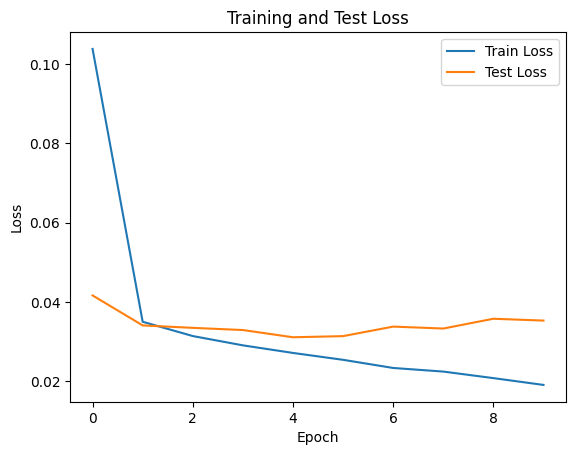

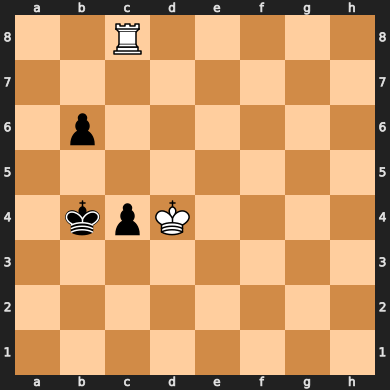

Top 5 predicted moves (start, end, uci, score):
b4b5: 0.7323
b4b3: 0.5601
b6b5: 0.4537
b6b3: 0.3471
b4c3: 0.0704

Ground Truth Move: b6b5


In [5]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()

import utils
import chess

def get_top_5_moves(pred_tensor):
    pred = torch.sigmoid(pred_tensor).detach().cpu().numpy()  # shape (2, 8, 8)
    start_flat = pred[0].flatten()
    end_flat = pred[1].flatten()
    
    moves = []
    for start in range(64):
        for end in range(64):
            score = start_flat[start] * end_flat[end]
            moves.append((score, start, end))

    top5 = sorted(moves, key=lambda x: -x[0])[:5]
    return [(chess.square_name(s), chess.square_name(e), f"{chess.square_name(s)}{chess.square_name(e)}", float(score)) for score, s, e in top5]

# Pick a test sample
idx = np.random.randint(len(X_test))
x = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(device)
y_pred = model(x)[0]  # shape: (2, 8, 8)

board = utils.tensor_to_board(X_test[idx])
display(board)
top5_moves = get_top_5_moves(y_pred)

print("Top 5 predicted moves (start, end, uci, score):")
for start, end, uci, score in top5_moves:
    print(f"{uci}: {score:.4f}")

y_true = Y_test[idx]  # shape: (2, 8, 8)
# Find the '1' (or highest value) in the start plane and end plane
start_idx = np.argmax(y_true[0].flatten()) 
end_idx   = np.argmax(y_true[1].flatten()) 

# Convert to square names just like the predicted moves
start_sq = chess.square_name(start_idx)
end_sq   = chess.square_name(end_idx)
true_uci = f"{start_sq}{end_sq}"

print("\nGround Truth Move:", true_uci)

Top-1 Accuracy: 0.307
Top-5 Accuracy: 0.658


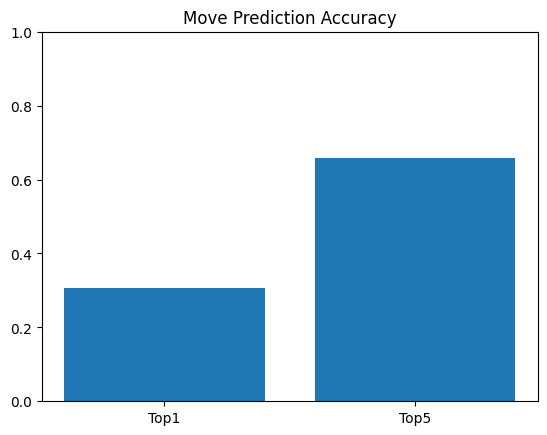

In [6]:
# New cell to compute and plot Top-1 and Top-5 Accuracy
import matplotlib.pyplot as plt

top1_correct = 0
top5_correct = 0
num_samples = len(X_test)

for i in range(num_samples):
    # Model prediction
    x = torch.tensor(X_test[i:i+1], dtype=torch.float32).to(device)
    y_pred = model(x)[0]  # shape: (2, 8, 8)

    # Ground-truth move (assuming y_test has shape [N, 2, 8, 8])
    y_true = Y_test[i]
    start_idx = np.argmax(y_true[0].flatten())  # index 0..63
    end_idx   = np.argmax(y_true[1].flatten())  # index 0..63
    gt_start  = chess.square_name(start_idx)    # e.g. "a2"
    gt_end    = chess.square_name(end_idx)      # e.g. "a3"

    # Get predicted top-5 moves
    # (start_str, end_str, uci_str, score)
    top5_moves = get_top_5_moves(y_pred)

    # Check if Top-1 matches ground truth
    top1_move = top5_moves[0]
    if top1_move[0] == gt_start and top1_move[1] == gt_end:
        top1_correct += 1

    # Check if ground truth is in Top-5
    for (start_str, end_str, uci_str, score) in top5_moves:
        if start_str == gt_start and end_str == gt_end:
            top5_correct += 1
            break

top1_accuracy = top1_correct / num_samples
top5_accuracy = top5_correct / num_samples

print(f"Top-1 Accuracy: {top1_accuracy:.3f}")
print(f"Top-5 Accuracy: {top5_accuracy:.3f}")

# Plot as a simple bar chart
plt.bar(["Top1", "Top5"], [top1_accuracy, top5_accuracy])
plt.ylim(0, 1)
plt.title("Move Prediction Accuracy")
plt.show()